This notebook includes:
- Exploration of Vesiclepedia and Exocarta datasets
- Curation and merging of Vesiclepedia and Exocarta datasets
- Mapping of EV entries to UniProt IDs (via UniProt API)
- Data visualization (number of occurrences, dataset overlap) 
- Functional enrichment analysis of the top EV proteins

Output datasets:
- VPEC_all.csv
- VPEC_mapped.csv
- VP_old_mapped.csv

# Import libraries

In [1]:
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import urllib.parse
import urllib.request
import os

import gseapy as gp
from gseapy.plot import barplot, dotplot
from matplotlib_venn import venn2, venn3 
import warnings
warnings.filterwarnings("ignore")

# Define data path

In [2]:
Data_path = os.path.dirname(os.getcwd()) + '/Data'

# Import data sets

### Vesiclepedia

In [3]:
# load raw Vesiclepedia datasets
vesiclepedia = Data_path + '/raw/vesiclepedia.txt'
vesiclepedia_experiments = Data_path + '/raw/vesiclepedia_experiments.txt'
VP = pd.read_csv(vesiclepedia, sep='\t', engine='python')
VP_experiments = pd.read_csv(vesiclepedia_experiments, sep='\t', engine='python')

# merge experiment details with content data frame 
VP_all = VP.merge(VP_experiments[["EXPERIMENT ID", "PUBMED ID", "EXPERIMENT DESCRIPTION", "YEAR", "ISOLATION METHOD", 
    "VESICLE TYPE"]], on="EXPERIMENT ID", how="inner")

### Exocarta

In [4]:
# load raw Exocarta datasets
exocarta = Data_path + '/raw/exocarta.csv'
exocarta_experiments = Data_path + '/raw/exocarta_experiments.txt'
EC = pd.read_csv(exocarta, sep=';', engine='python')
EC_experiments = pd.read_csv(exocarta_experiments, sep='\t', engine='python')

### UniProt human proteome

In [5]:
# load all information from UniProt human proteins
UP = Data_path + '/raw/UniProt/uniprot_9606.tab'
UP = pd.read_csv(UP, sep='\t', engine='python')

In [6]:
print('Vesiclepedia')
print('Unique genes: ', len(VP['ENTREZ GENE ID'].value_counts()))
print('Unique species: ', len(VP['SPECIES'].value_counts()))
print('Unique experiments:', len(VP_all['EXPERIMENT ID'].value_counts())) # some experiments not in cargo dataset
print('------------------')
print('Exocarta')
print('Unique genes: ', len(EC['ENTREZ GENE ID'].value_counts()))
print('Unique species: ', len(EC['SPECIES'].value_counts()))

Vesiclepedia
Unique genes:  34913
Unique species:  35
Unique experiments: 1141
------------------
Exocarta
Unique genes:  12210
Unique species:  7


# Data curation

In [7]:
# curation functions

def filtering(df):
    df = df[df['CONTENT TYPE'] == "protein"] # select proteins
    df = df[df['SPECIES'] == 'Homo sapiens'] # select human proteins
    return df

def instance_count(df): 
    df_copy = df.copy()
    df_copy['OCCURRENCES'] = df_copy.groupby('ENTREZ GENE ID')['ENTREZ GENE ID'].transform('count') # calculate occurrences
    df_copy = df_copy.drop_duplicates(subset=['ENTREZ GENE ID'], keep='first') # keep a single value per protein
    if 'VESICLE TYPE' in df_copy.columns:
        df_copy = df_copy[['ENTREZ GENE ID', 'GENE SYMBOL', 'OCCURRENCES', 'VESICLE TYPE']]  # rename columns 
    else:
        df_copy = df_copy[['ENTREZ GENE ID', 'GENE SYMBOL', 'OCCURRENCES']]  # rename columns 
    return df_copy

## EV dataset 1 (full EV dataset, no filtering)

In [8]:
VP_filtered = filtering(VP_all)
VP_curated = instance_count(VP_filtered)
print('Number of filtered unique genes in Vesiclepedia:', len(VP_curated))
EC_filtered = filtering(EC)
EC_curated = instance_count(EC_filtered)
print('Number of filtered unique genes in Exocarta:', len(EC_curated))
print('-------------------')
VPEC = pd.concat([VP_curated, EC_curated])
VPEC = VPEC.drop_duplicates(subset=['ENTREZ GENE ID'], keep='first') # keep instances from Vesiclepedia
VPEC = VPEC.drop("VESICLE TYPE", axis=1)
print('Combined number of filtered unique genes:', len(VPEC))

Number of filtered unique genes in Vesiclepedia: 13550
Number of filtered unique genes in Exocarta: 5409
-------------------
Combined number of filtered unique genes: 13648


### Mapping Entrez to Uniprot

In [9]:
# ID mapping from GeneID to UniProtKB (https://www.uniprot.org/id-mapping)
# import mapping
mapping = pd.read_csv(Data_path + '/Mapping/all_EV_proteins_Entrez_to_Uniprot.tsv' , sep='\t', header=0, 
    names=["ENTREZ GENE ID", "Uniprot"])
print("Number of mappings:", len(mapping))

# drop duplicates, keep first entry
mapping.drop_duplicates(subset=["ENTREZ GENE ID"], inplace=True)
mapping.drop_duplicates(subset=["Uniprot"])
print("Number of unique Entrez to Uniprot mappings:", len(mapping["ENTREZ GENE ID"].unique()))

# remove entries that are not part of the human proteome
mapping = mapping[mapping["Uniprot"].isin(UP["Entry"])]
print("Number of unique Entrez to human proteome Uniprot mappings:", len(mapping["ENTREZ GENE ID"].unique()))

Number of mappings: 23269
Number of unique Entrez to Uniprot mappings: 12794
Number of unique Entrez to human proteome Uniprot mappings: 11952


In [10]:
VPEC_mapped = VPEC.merge(mapping, on="ENTREZ GENE ID")
VPEC_mapped[:5].sort_values("GENE SYMBOL")

,ENTREZ GENE ID,GENE SYMBOL,OCCURRENCES,Uniprot
0,16,AARS,124,P49588
1,34,ACADM,42,P11310
2,38,ACAT1,65,P24752
3,47,ACLY,185,P53396
4,50,ACO2,58,Q99798


## EV dataset 2 (isolation method filtering)

Requirements:
- No ExoQuick or Isolation Kits
- At least three isolation steps
- No Ultracentrifugation before the third step
- Size or density-based filtration step first
- At least two filtration steps at the beginning

In [11]:
isolation_methods = ["Differential centrifugation|Filtration|Ultracentrifugation",
    "Differential centrifugation|Polymer-based precipitation|Ultracentrifugation",
    "Differential centrifugation|Filtration|Ultracentrifugation|Density gradient centrifugation",
    "Differential centrifugation|Filtration|Sucrose density gradient",
    "Differential centrifugation|Filtration|Ultrafiltration",
    "Microfiltration|Differential centrifugation|Ultracentrifugation",
    "Differential centrifugation|Filtration|Ultrafiltration|Ultracentrifugation|Sucrose density gradient",
    "Differential centrifugation|Filtration|Ultrafiltration|Ultracentrifugation",
    "Hydrostatic filtration dialysis|Differential centrifugation|Ultracentrifugation",
    "Differential centrifugation|Ultrafiltration|Ultracentrifugation|Density gradient centrifugation",
    "Differential centrifugation|Sucrose density gradient|Ultracentrifugation",
    "Differential centrifugation|Hydrostatic filtration dialysis|Ultrafiltration",
    "Differential centrifugation|Sucrose density gradient|Diafiltration",
    "Differential centrifugation|Filtration|Ultracentrifugation|Gel filtration",
    "Differential centrifugation|Filtration|Sucrose density gradient|Ultracentrifugation",
    "Filtration|Size exclusion chromatography|Sucrose density gradient",
    "Differential centrifugation|Sucrose density gradient|Size exclusion chromatography",
    "Differential centrifugation|Gel filtration|Ultracentrifugation"]

# filter Vesiclepedia database based on workflow for EV isolation
VP_iso = VP_all[VP_all["ISOLATION METHOD"].isin(isolation_methods)]

In [12]:
print('Number of filtered unique genes in Vesiclepedia:', len(VP_curated)) # to compare
VP_iso_filtered = filtering(VP_iso)
VP_iso_curated = instance_count(VP_iso_filtered)
print('Number of filtered unique genes in Vesiclepedia (isolation method filtered):', len(VP_iso_curated))

Number of filtered unique genes in Vesiclepedia: 13550
Number of filtered unique genes in Vesiclepedia (isolation method filtered): 6818


In [13]:
VP_iso_mapped = VP_iso_curated.merge(mapping, on="ENTREZ GENE ID")
print("Number of unique Entrez to human proteome Uniprot mappings:", len(VP_iso_mapped))

Number of unique Entrez to human proteome Uniprot mappings: 6678


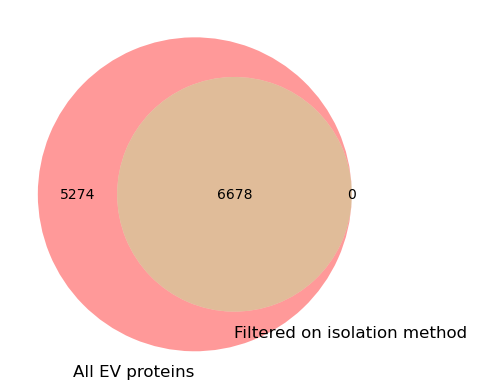

In [14]:
venn2([set(VPEC_mapped["ENTREZ GENE ID"]), set(VP_iso_mapped["ENTREZ GENE ID"])], 
    ["All EV proteins", "Filtered on isolation method"])
plt.show()

## Save data sets

In [15]:
VPEC_mapped.to_csv(Data_path + '/curated/VPEC_all.csv', index=False)
VP_iso_mapped.to_csv(Data_path + '/curated/VP_Isolation_filter.csv', index=False)

# Low confidence EV protein sets 

EV studies published before 2010

In [16]:
# filter based on the year of the study
VP_old = VP_all[VP_all["YEAR"] < 2010]
# apply the same filtering as for the other datasets and map to UniProt
VP_old_filtered = filtering(VP_old)
VP_old_curated = instance_count(VP_old)
VP_old_mapped = VP_old_curated.merge(mapping, on="ENTREZ GENE ID")
print("Number of unique Entrez to human proteome Uniprot mappings from old studies:", len(VP_old_mapped))
#save
VP_old_mapped.to_csv(Data_path + '/curated/VP_old_mapped.csv', index=False)
VP_old_mapped

Number of unique Entrez to human proteome Uniprot mappings from old studies: 9506


,ENTREZ GENE ID,GENE SYMBOL,OCCURRENCES,VESICLE TYPE,Uniprot
0,16,AARS,10,Microparticles,P49588
1,34,ACADM,6,Microparticles,P11310
2,38,ACAT1,12,Microparticles,P24752
3,47,ACLY,25,Microparticles,P53396
4,50,ACO2,8,Microparticles,Q99798
...,...,...,...,...,...
9501,958,CD40,2,Exosomes,P25942
9502,2651,GCNT2,1,Exosomes,Q8N0V5
9503,7306,TYRP1,1,Exosomes,P17643
9504,1234,CCR5,1,Microparticles,P51681


# Top EV proteins - Functional enrichment analysis

In [17]:
df_filtered = pd.read_csv(Data_path + "/curated/VP_Isolation_filter.csv")
df = df_filtered[df_filtered['OCCURRENCES'] >= 30]

In [18]:
enr2 = gp.enrichr(gene_list=df['GENE SYMBOL'],
                 gene_sets='KEGG_2019_Human',
                 cutoff=0.5)

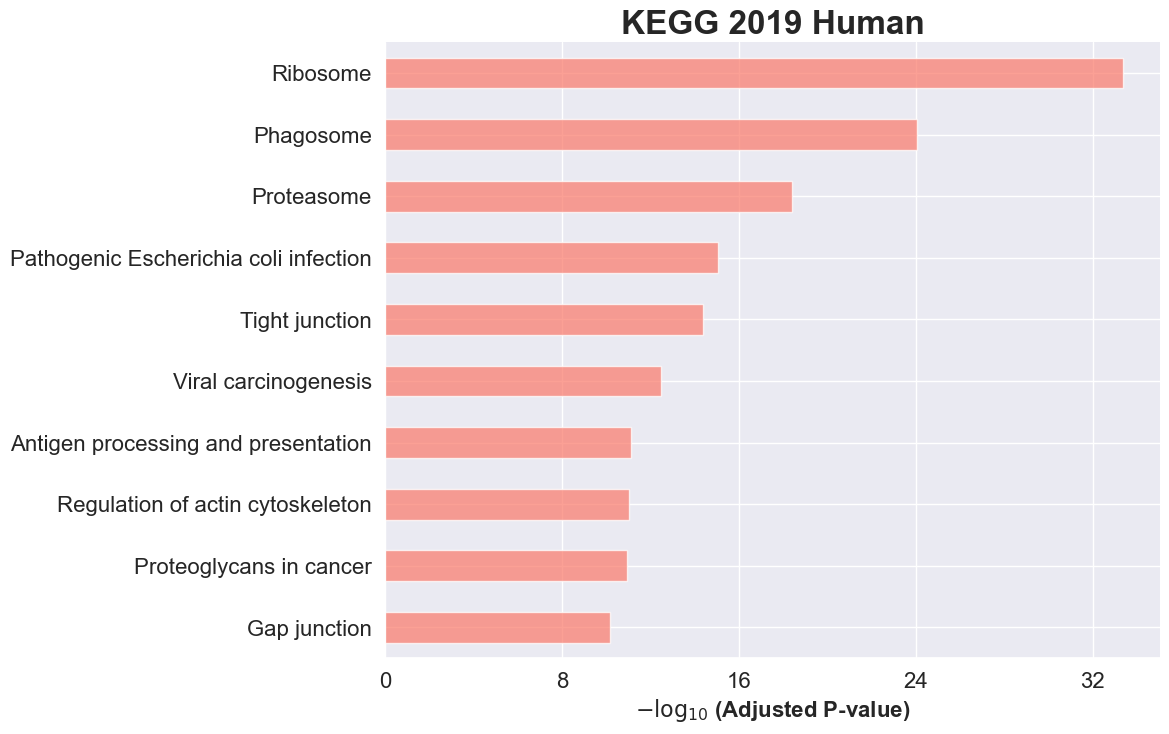

In [19]:
sns.set(font_scale = 1.3)
barplot(enr2.res2d, title='KEGG 2019 Human', figsize=(10,8))
fig = plt.gcf()
plt.show()